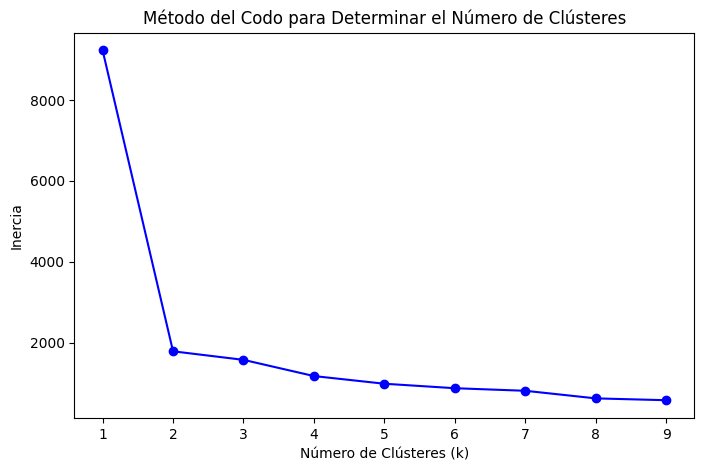

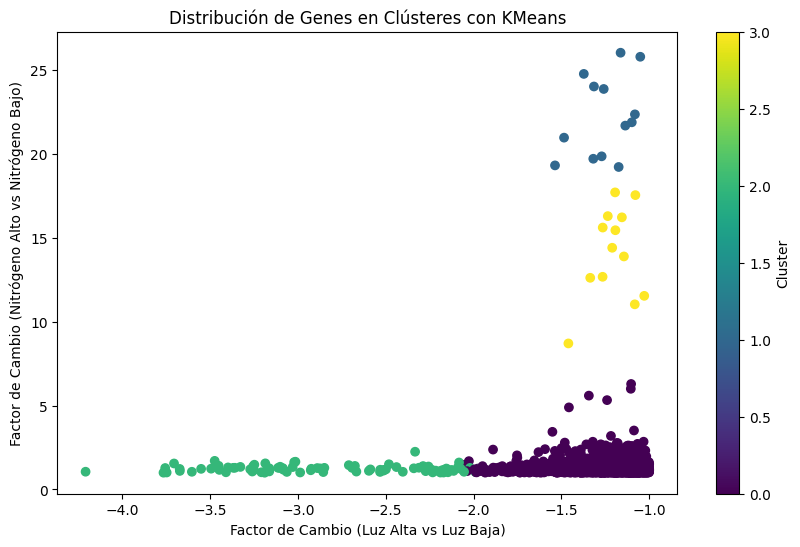

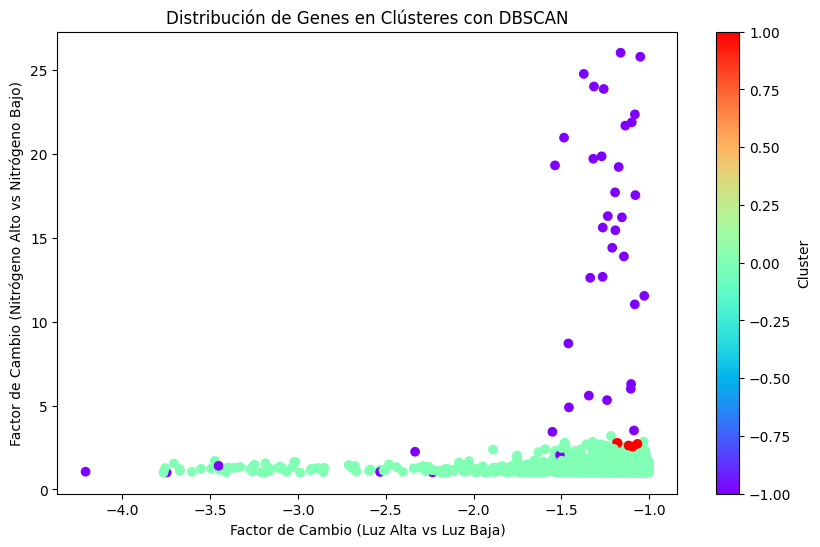

Genes agrupados por KMeans:
Cluster
0    [moxR, nan, nan, Unknown, nan, No Sim, pgi, Un...
1    [gyrB, Unknown, RLUB, No Sim, vapC, nan, TR-as...
2    [Lipoprotein, Lipoprotein, Unknown, nan, Lipop...
3    [Two comp his sens, Unknown, Unknown, Transam,...
Name: Gene_Name, dtype: object

Genes agrupados por DBSCAN:
Cluster
-1    [No Sim, Unknown, Unknown, No Sim, pckA, ppsA,...
 0    [Lipoprotein, Lipoprotein, Unknown, moxR, nan,...
 1             [Two comp reg, recA, Unknown, hoxE, nan]
Name: Gene_Name, dtype: object


In [ ]:
# Importar las bibliotecas necesarias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN

# Cargar el dataset desde Google Drive o local (debes ajustar el path según el archivo que uses en Colab)
file_path = '/content/1-s2.0-S2211926418309305-mmc3.xlsx'
dataset = pd.read_excel(file_path)

# Renombrar las columnas para mayor claridad
dataset.columns = [
    'L3N2_Low_High_Light', 'Probe_ID', 'MAE_NIES843', 'Gene_Name', 'P_Value',
    'FC_L3N2_vs_L2N2', 'Regulation_L3N2_vs_L2N2', 'FC_L1N2_vs_L2N2',
    'Regulation_L1N2_vs_L2N2', 'Empty_Column', 'L3N2_High_High_Light', 'Probe_Name',
    'MAE_Additional', 'Gene_Desc', 'P_Corr', 'FC_High_L3N2_vs_L2N2',
    'Regulation_High_L3N2_vs_L2N2', 'FC_High_L1N2_vs_L2N2', 'Regulation_High_L1N2_vs_L2N2'
]

# Eliminar la columna completamente vacía
dataset_cleaned = dataset.drop(columns=['Empty_Column'])

# Convertir los factores de cambio a numéricos y eliminar valores nulos
features = dataset_cleaned[['FC_L3N2_vs_L2N2', 'FC_L1N2_vs_L2N2', 'FC_High_L3N2_vs_L2N2', 'FC_High_L1N2_vs_L2N2']]
features = features.apply(pd.to_numeric, errors='coerce').dropna()

# Método del codo para determinar el número óptimo de clústeres en KMeans
inertia = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar el Número de Clústeres')
plt.show()

# Aplicar K-Means con un número óptimo de clústeres (ejemplo: k=4)
kmeans_model = KMeans(n_clusters=4, random_state=42)
kmeans_clusters = kmeans_model.fit_predict(features)

# Añadir los clústeres de KMeans al DataFrame
kmeans_data = features.copy()
kmeans_data['Cluster'] = kmeans_clusters

# Visualizar los resultados de los clústeres KMeans
plt.figure(figsize=(10, 6))
plt.scatter(kmeans_data['FC_L3N2_vs_L2N2'], kmeans_data['FC_High_L3N2_vs_L2N2'],
            c=kmeans_data['Cluster'], cmap='viridis', label='Clusters')
plt.colorbar(label='Cluster')
plt.xlabel('Factor de Cambio (Luz Alta vs Luz Baja)')
plt.ylabel('Factor de Cambio (Nitrógeno Alto vs Nitrógeno Bajo)')
plt.title('Distribución de Genes en Clústeres con KMeans')
plt.show()

# Aplicar DBSCAN
dbscan_model = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan_model.fit_predict(features)

# Añadir los clústeres de DBSCAN al DataFrame
dbscan_data = features.copy()
dbscan_data['Cluster'] = dbscan_clusters

# Visualizar los resultados de los clústeres DBSCAN
plt.figure(figsize=(10, 6))
plt.scatter(dbscan_data['FC_L3N2_vs_L2N2'], dbscan_data['FC_High_L3N2_vs_L2N2'],
            c=dbscan_data['Cluster'], cmap='rainbow', label='Clusters')
plt.colorbar(label='Cluster')
plt.xlabel('Factor de Cambio (Luz Alta vs Luz Baja)')
plt.ylabel('Factor de Cambio (Nitrógeno Alto vs Nitrógeno Bajo)')
plt.title('Distribución de Genes en Clústeres con DBSCAN')
plt.show()

# Añadir los nombres de los genes para interpretar los clústeres
kmeans_data['Gene_Name'] = dataset_cleaned.loc[features.index, 'Gene_Name']
dbscan_data['Gene_Name'] = dataset_cleaned.loc[features.index, 'Gene_Name']

# Agrupar por clúster y mostrar los genes de KMeans y DBSCAN
kmeans_clusters_genes = kmeans_data.groupby('Cluster')['Gene_Name'].apply(list)
dbscan_clusters_genes = dbscan_data.groupby('Cluster')['Gene_Name'].apply(list)

# Mostrar los resultados de los genes agrupados
print("Genes agrupados por KMeans:")
print(kmeans_clusters_genes)

print("\nGenes agrupados por DBSCAN:")
print(dbscan_clusters_genes)


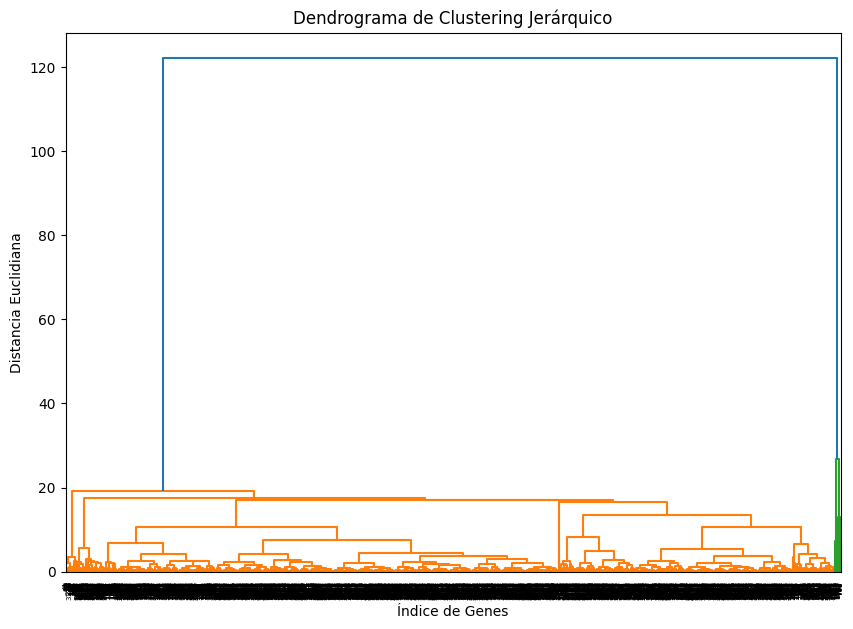

Genes agrupados en 3 clústeres según similitudes génicas:
Cluster
1    [Lipoprotein, Lipoprotein, Unknown, moxR, nan,...
2    [Two comp his sens, Unknown, nan, nan, Unknown...
3    [gyrB, Unknown, RLUB, No Sim, vapC, nan, TR-as...
Name: Gene_Name, dtype: object


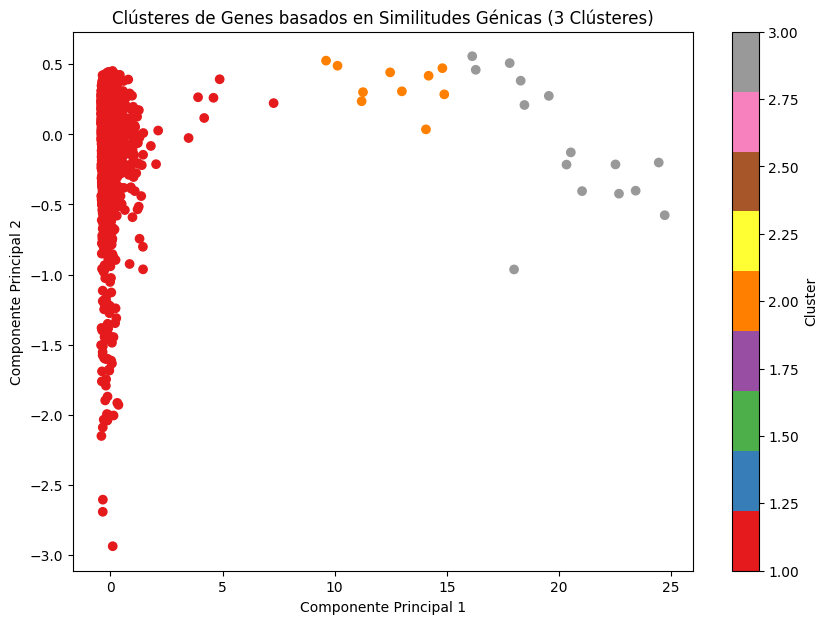

In [ ]:
# Importar bibliotecas necesarias
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA

# Cargar el dataset
file_path = '/content/1-s2.0-S2211926418309305-mmc3.xlsx'  # Ajusta el path según el archivo en Colab
dataset = pd.read_excel(file_path)

# Renombrar columnas para claridad
dataset.columns = [
    'L3N2_Low_High_Light', 'Probe_ID', 'MAE_NIES843', 'Gene_Name', 'P_Value',
    'FC_L3N2_vs_L2N2', 'Regulation_L3N2_vs_L2N2', 'FC_L1N2_vs_L2N2',
    'Regulation_L1N2_vs_L2N2', 'Empty_Column', 'L3N2_High_High_Light', 'Probe_Name',
    'MAE_Additional', 'Gene_Desc', 'P_Corr', 'FC_High_L3N2_vs_L2N2',
    'Regulation_High_L3N2_vs_L2N2', 'FC_High_L1N2_vs_L2N2', 'Regulation_High_L1N2_vs_L2N2'
]

# Eliminar la columna vacía y convertir a numéricos
dataset_cleaned = dataset.drop(columns=['Empty_Column'])
features = dataset_cleaned[['FC_L3N2_vs_L2N2', 'FC_L1N2_vs_L2N2', 'FC_High_L3N2_vs_L2N2', 'FC_High_L1N2_vs_L2N2']]
features = features.apply(pd.to_numeric, errors='coerce').dropna()

# Aplicar clustering jerárquico y crear el dendrograma
Z = linkage(features, method='ward')  # Utiliza el método de Ward para optimizar la varianza
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice de Genes')
plt.ylabel('Distancia Euclidiana')
plt.show()

# Cortar el dendrograma en 3 clústeres
clusters = fcluster(Z, 3, criterion='maxclust')

# Añadir la información de clústeres al DataFrame
features['Cluster'] = clusters
features['Gene_Name'] = dataset_cleaned.loc[features.index, 'Gene_Name']

# Visualizar los genes agrupados en 3 clústeres
cluster_groups = features.groupby('Cluster')['Gene_Name'].apply(list)
print("Genes agrupados en 3 clústeres según similitudes génicas:")
print(cluster_groups)

# Reducir dimensiones para visualizar los clústeres en un gráfico 2D
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features.drop(columns=['Cluster', 'Gene_Name']))

# Graficar los clústeres en un gráfico de dispersión
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=features['Cluster'], cmap='Set1')
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clústeres de Genes basados en Similitudes Génicas (3 Clústeres)')
plt.show()


In [ ]:
# Filtrar y mostrar los genes del Clúster 1
genes_cluster_1 = features[features['Cluster'] == 1]['Gene_Name']
print("Genes en el Clúster 1:")
print(genes_cluster_1)



Genes en el Clúster 1:
2       Lipoprotein
3       Lipoprotein
4           Unknown
5              moxR
6               NaN
           ...     
3260        Unknown
3261           hlyD
3262            NaN
3263            NaN
3264            NaN
Name: Gene_Name, Length: 3238, dtype: object


Índice de Silueta: 0.9416118496180784
Coeficiente de Davies-Bouldin: 0.4161896779059209


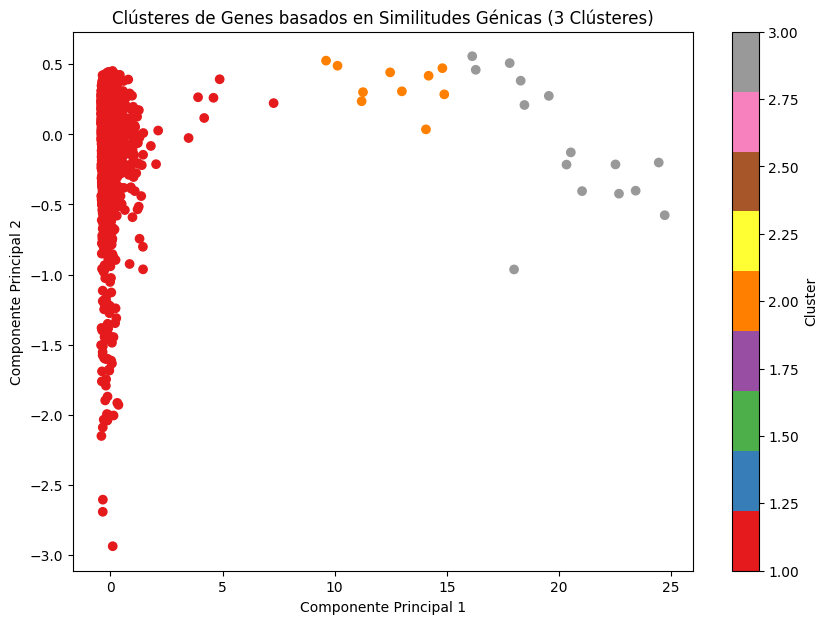

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Extraer los valores numéricos sin la columna 'Gene_Name'
features_numerics = features.drop(columns=['Cluster', 'Gene_Name'])

# Validar el modelo de clustering jerárquico
silhouette_avg = silhouette_score(features_numerics, features['Cluster'])
davies_bouldin_avg = davies_bouldin_score(features_numerics, features['Cluster'])

print(f"Índice de Silueta: {silhouette_avg}")
print(f"Coeficiente de Davies-Bouldin: {davies_bouldin_avg}")

# Visualizar los clústeres
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=features['Cluster'], cmap='Set1')
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clústeres de Genes basados en Similitudes Génicas (3 Clústeres)')
plt.show()
